This dataset is a collection of attributes of startup companies linked to their dependent variable of success. It can be found at https://www.kaggle.com/datasets/manishkc06/startup-success-prediction, with data provided by Ramkishan Panthena.

In this notebook, the dataset will be processed minimally and then passed through an unaltered skelearn logistic regression model. The purpose of this will be to establish a baseline which can be used to guide later EDA and compare to later models. Next, a logistic regression model that utilizes a penalty will be implemented in order to improve accuracy. 

Models will be scored by accuracy, F1 score, and ROC AUC. 
* Accuracy is a measure of correctly classified observations.
* F1 score takes both precision and recall into account, and is useful at detecting imbalance in classification.
* ROC AUC measures the true positive rate abd false positive rate.

For all three measures, the threshold for 'acceptable' will be set at 0.7, with higher numbers being much more desirable. However, the maximum of these numbers depends greatly on how much predictive power is able to be realistically obtained from the dataset.  

In [46]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt

In [43]:
df = pd.read_csv('startup_data.csv')
df.head()

,Unnamed: 0,state_code,latitude,longitude,zip_code,id,city,Unnamed: 6,name,labels,...,object_id,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,1005,CA,42.358880,-71.056820,92101,c:6669,San Diego,NaN,Bandsintown,1,...,c:6669,0,1,0,0,0,0,1.0000,0,acquired
1,204,CA,37.238916,-121.973718,95032,c:16283,Los Gatos,NaN,TriCipher,1,...,c:16283,1,0,0,1,1,1,4.7500,1,acquired
2,1001,CA,32.901049,-117.192656,92121,c:65620,San Diego,San Diego CA 92121,Plixi,1,...,c:65620,0,0,1,0,0,0,4.0000,1,acquired
3,738,CA,37.320309,-122.050040,95014,c:42668,Cupertino,Cupertino CA 95014,Solidcore Systems,1,...,c:42668,0,0,0,1,1,1,3.3333,1,acquired
4,1002,CA,37.779281,-122.419236,94105,c:65806,San Francisco,San Francisco CA 94105,Inhale Digital,0,...,c:65806,1,1,0,0,0,0,1.0000,1,closed


Many of these values are categorical and cannot be fed into the model. At this stage, they will be dropped. Redundant attributes (such as multiple location attributes) or irrelevant attributes will also be dropped.

Since the target variable is categorical, it will be converted to a numeric Boolean.

In [3]:
df['status'] = df['status'].map({'acquired': 1, 'closed': 0})

objects = df.select_dtypes(include=['object']).columns
others = ['age_first_milestone_year', 'age_last_milestone_year', 'Unnamed: 0', 'labels', 'latitude', 'longitude']
df.drop(objects, axis=1, inplace=True)
df.drop(others, axis=1, inplace=True)
print(df.shape)
df.head()

(923, 30)


,age_first_funding_year,age_last_funding_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,is_NY,is_MA,is_TX,...,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,2.2493,3.0027,3,3,375000,3,1,0,0,0,...,1,0,1,0,0,0,0,1.0000,0,1
1,5.1260,9.9973,9,4,40100000,1,1,0,0,0,...,0,1,0,0,1,1,1,4.7500,1,1
2,1.0329,1.0329,5,1,2600000,2,1,0,0,0,...,0,0,0,1,0,0,0,4.0000,1,1
3,3.1315,5.3151,5,3,40000000,1,1,0,0,0,...,0,0,0,0,1,1,1,3.3333,1,1
4,0.0000,1.6685,2,2,1300000,1,1,0,0,0,...,0,1,1,0,0,0,0,1.0000,1,0


In [4]:
# Splitting the dataset into independent and dependent subsets. 
X, y = df.iloc[:,:-1], df.iloc[:, -1:]
y = y.values.reshape(923,)
print(X.shape)
print(y.shape)

(923, 29)
(923,)


Below, an unaltered logistic regression is performed on the data. 

In [9]:
mod = LogisticRegression()
scores = cv_results = cross_validate(mod, X, y, cv=5, scoring=('accuracy', 'f1', 'roc_auc'), return_train_score=True)
test_accuracy = np.mean(scores['test_accuracy'])
test_f1 = np.mean(scores['test_f1'])
test_roc = np.mean(scores['test_roc_auc'])
print(f'Test accuracy: {test_accuracy}\nTest F1 score: {test_f1}\nTest ROC AUC: {test_roc}')

Test accuracy: 0.6468037602820212
Test F1 score: 0.7855244648709909
Test ROC AUC: 0.6554068676421618


A k = 5 k-folds cross validation was run on the data, with test accuracy, F1 score, and ROC AUC measured and displayed. These measures are somewhat decent, but there is likely much room for improvement.

Next, some of the hyperparameters of the logistic model will be altered in an effort to improve performance. 

In [12]:
# Implementation and testing of a logistic regression model using a penalty.
mod_params = LogisticRegression(penalty='l1', solver='liblinear')
scores_params = cross_validate(mod_params, X, y, cv=5, scoring=('accuracy', 'f1', 'roc_auc'), return_train_score=True)
test_accuracy_params = np.mean(scores_params['test_accuracy'])
test_f1_params = np.mean(scores_params['test_f1'])
test_roc_params = np.mean(scores_params['test_roc_auc'])
print(f'Test accuracy: {test_accuracy_params}\nTest F1 score: {test_f1_params}\nTest ROC AUC: {test_roc_params}')

Test accuracy: 0.7616627497062279
Test F1 score: 0.8246149925518512
Test ROC AUC: 0.7894345458463106


Adding the L1 pentalty resulted in a significant performance improvement, bringing the three scores above the predetermined threshold of acceptability.

Below, the attribute coefficients of this improved model are obtained. A startup being entered into the Top 500 is unsurprisingly a good indicator of success according to this model. However, some of the more interesting results indicate the importance of state or category of the startup. 

In [7]:
mod_params.fit(X, y)
coeffs_params = mod_params.coef_[0]

attr_coeffs_params = {}
attrs = df.columns
for i in range(len(coeffs_params)):
    attr_coeffs_params[attrs[i]] = coeffs_params[i]
attr_coeffs_params = dict(sorted(attr_coeffs_params.items(), key=lambda item: item[1], reverse=True))
attr_coeffs_params

{'is_top500': 0.8049383250900236,
 'milestones': 0.3641491993697081,
 'has_roundD': 0.3460581859762578,
 'is_MA': 0.34279914291879193,
 'is_enterprise': 0.3185959762605008,
 'is_NY': 0.2236049863291411,
 'is_software': 0.22064387004123776,
 'is_biotech': 0.1878108367510234,
 'has_roundC': 0.13570930923866048,
 'relationships': 0.13483742369594717,
 'avg_participants': 0.1024317440075453,
 'has_roundB': 0.05327307064004999,
 'funding_rounds': 0.037914850679753274,
 'age_last_funding_year': 0.033341564344848834,
 'is_CA': 0.0,
 'is_advertising': 0.0,
 'is_consulting': 0.0,
 'has_roundA': 0.0,
 'funding_total_usd': -3.276629279828302e-11,
 'age_first_funding_year': -0.03344811089103968,
 'is_web': -0.05927336967699924,
 'is_othercategory': -0.06013514345079142,
 'is_mobile': -0.22399861219142406,
 'is_otherstate': -0.24143779684102956,
 'has_angel': -0.2447443098364887,
 'is_gamesvideo': -0.30771361951707404,
 'has_VC': -0.33288885375953675,
 'is_TX': -0.3454963117972714,
 'is_ecommerce':

Text(0, 0.5, 'Coefficient')

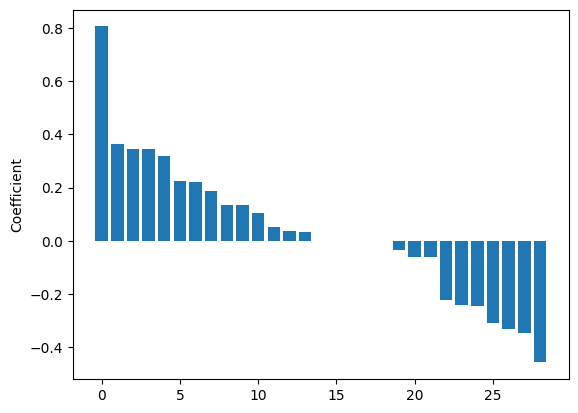

In [50]:
attrs_plot = range(29)
coeffs_plot = attr_coeffs_params.values()

plt.bar(attrs_plot, coeffs_plot)
plt.ylabel('Coefficient')

In summary, the performance of the model that utilized an L1 penalty performed much better than the native model, as determined by the above scoring metrics. Due to the relatively high performance of the optimized model, parameter coefficients were obtained from the trained model. The above chart shows the relative intensities of each variable coefficient. Note that x labels were not included due to much too high of density for many words, though relative order can be assessed via the dictionary above the plot. The plot indicates that much of the predictive power is in the top attribute of 'is_top500', with several of the attributes in the middle dropped. 

Though these results are acceptable, more interpretable and more powerful models are explored in the following notebooks. 